 # Data Analysis and Predictive Model Training - OuiBikes

The following notebook is a review of the data quality used for the training of our predictor model, as well as the steps taken to train and improve the model itself. Within our database, the important data to be processed and used is stored in two seperate tables:

* dublinbikes.station_status - updated every six minutes and contains all the dynamic data for each bike station
* dublinbikes.current_weather - updated every 30 minutes and contains all the data relating to weather in Dublin

For the purpose of data processing and model training, it was agreed as a group to write a single SQL query that would load both these tables as a single dataframe for examination and manipulation. The data taken from both tables would be averaged into an hourly sample. This would simplify the process of data processing, especially with the weather and bike information recorded at different time intervals. 

Within this notebook, all API keys/passwords will be redacted, as the intention is to host this notebook and its code publicly on GitHub. Should a working demonstration of the data processing and model be required, please get in contact with one of the team members on the project.

### SQL Combined Data Query

In [86]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
import datetime
import pickle
import math
from IPython.display import Image

In [ ]:
URI = 'REDACTED'
DB = ***REMOVED***
PORT = "REDACTED"
USER = "REDACTED"
PASSWORD = "REDACTED"

engine = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format(USER, PASSWORD, URI, PORT, DB), echo=True)

def sql_query_model():
    ''' SQL Query to retrieve bike station data and weather data from two seperate tables and combine them
    into a single dataframe for data processing. The time sample for both data will be set to hourly using
    the averages of the data.
    '''
    
    conn = engine.connect()
    
    sql1 = """SELECT number, date_format(CAST(last_update AS DATETIME), '%%Y-%%m-%%d %%H' ) as myDate, AVG(available_bike_stands) as available_bike_stands, AVG(available_bikes) as available_bikes
            FROM station_status
            GROUP BY number, myDate
            ORDER BY myDate ASC;"""
        
    df1 = pd.read_sql_query(sql1, conn)
    df1['myDate'] = pd.to_datetime(df1.myDate, unit='ns')
    df1['myDate'] = df1.myDate.map(lambda x: x.replace(minute=0, second=0))
    
    sql2 = """SELECT date_format(CAST(last_update AS DATETIME), '%%Y-%%m-%%d %%H' ) as myDate, main_weather, (AVG(`main.temp`) -273.15) as main_temp, AVG(rainfall_mm) as rainfall_mm, AVG(`wind.speed`) as wind_speed
            FROM current_weather
            GROUP BY myDate
            ORDER BY myDate ASC;"""
    
    df2 = pd.read_sql_query(sql2, conn)
    df2['myDate'] = pd.to_datetime(df2.myDate, unit='ns')
    df2['myDate'] = df2.myDate.map(lambda x: x.replace(minute=0, second=0))
      
    df3 = pd.merge(df1, df2, on='myDate')
    
    for index, row in df3.iterrows():
        if df3.loc[index,'myDate'].hour == 0:
            df3.loc[index,'myDate'] = df3.loc[index,'myDate'] - datetime.timedelta(minutes=(df3.loc[index,'myDate'].minute + 1))
            df3.loc[index,'hour'] = 24
        else:
            df3.loc[index,'hour'] = (df3.loc[index,'myDate'].hour)
            
    df3['weekday'] = df3['myDate'].dt.day_name()
    df3.set_index('myDate', inplace=True)
    
    return df3

In [3]:
df_db = sql_query_model()

2019-04-19 07:27:41,356 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2019-04-19 07:27:41,358 INFO sqlalchemy.engine.base.Engine {}
2019-04-19 07:27:41,470 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2019-04-19 07:27:41,471 INFO sqlalchemy.engine.base.Engine {}
2019-04-19 07:27:41,693 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2019-04-19 07:27:41,695 INFO sqlalchemy.engine.base.Engine {}
2019-04-19 07:27:41,917 INFO sqlalchemy.engine.base.Engine show collation where `Charset` = 'utf8mb4' and `Collation` = 'utf8mb4_bin'
2019-04-19 07:27:41,918 INFO sqlalchemy.engine.base.Engine {}
2019-04-19 07:27:42,031 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2019-04-19 07:27:42,033 INFO sqlalchemy.engine.base.Engine {}
2019-04-19 07:27:42,146 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2019-04-19 07:27:42,147 INFO sqlalchemy.engine.base.E

## Data Quality Report

A first step for data analysis and processing is to check the quality of the data to be used. This will indentify issues such as NaN entries, outliers and the type of data to be processed (categorical or continuous). 

### - Check how many rows and columns the loaded data has

In [6]:
# Print the number of rows and columns
df_db.shape

(127012, 9)

A total of 127,012 rows of data are present, and there are nine columns/features contained within this dataframe.

### - Print the first and last five rows

In [8]:
# Print the first five rows of data
df_db.head(5)

,number,available_bike_stands,available_bikes,main_weather,main_temp,rainfall_mm,wind_speed,hour,weekday
myDate,,,,,,,,,
2019-02-21 23:00:00,95,1.2,38.8,Clouds,11.85,0.0,3.0,23.0,Thursday
2019-02-21 23:00:00,96,17.0,13.0,Clouds,11.85,0.0,3.0,23.0,Thursday
2019-02-21 23:00:00,91,4.5,25.5,Clouds,11.85,0.0,3.0,23.0,Thursday
2019-02-21 23:00:00,92,9.8,30.2,Clouds,11.85,0.0,3.0,23.0,Thursday
2019-02-21 23:00:00,87,12.0,26.0,Clouds,11.85,0.0,3.0,23.0,Thursday


In [10]:
# Print the last five rows of data
df_db.tail(5)

,number,available_bike_stands,available_bikes,main_weather,main_temp,rainfall_mm,wind_speed,hour,weekday
myDate,,,,,,,,,
2019-04-19 06:00:00,95,8.8,31.2,Mist,6.08,0.0,2.6,6.0,Friday
2019-04-19 06:00:00,93,6.0,34.0,Mist,6.08,0.0,2.6,6.0,Friday
2019-04-19 06:00:00,90,33.0,7.0,Mist,6.08,0.0,2.6,6.0,Friday
2019-04-19 06:00:00,91,30.0,0.0,Mist,6.08,0.0,2.6,6.0,Friday
2019-04-19 06:00:00,89,32.6,6.4,Mist,6.08,0.0,2.6,6.0,Friday


### Converting features to their appropriate data types (which features are more appropriate as continuous features, which are more appropriate as categorical features)

In [11]:
# Check each features current data type 
df_db.dtypes

number                     int64
available_bike_stands    float64
available_bikes          float64
main_weather              object
main_temp                float64
rainfall_mm              float64
wind_speed               float64
hour                     float64
weekday                   object
dtype: object

As it stands currently, all objects in our dataframe should be converted to categories. It is also important to note for the purpose of our modelling that the index is a datetime stamp. This will become important when we perform further sampling operations, as we are working with time series data. For the model training and cross validation, we must respect data entries and their chronological order. No training data should come *after* any of our testing or validation data. This would not make sense, as bike availability rises and falls based on the cycle of the working day. For example, I would expect less bikes available during the morning and evening on a work day, as this is rush hour. I might also expect a slight decline during lunch time, as people look to get places quickly for lunch.

In [31]:
# Select columns containing the aforementioned to be converted to categorical data type
categorical_columns = df_db[['main_weather', 'weekday']].columns

# For each data type in the list, convert it to categorical data
for column in categorical_columns:
    df_db[column] = df_db[column].astype('category')

In [32]:
# Check desired data types have been correctly converted
df_db.dtypes

number                      int64
available_bike_stands     float64
available_bikes           float64
main_weather             category
main_temp                 float64
rainfall_mm               float64
wind_speed                float64
hour                      float64
weekday                  category
dtype: object

### - Drop duplicate rows and columns, if any present

In [34]:
# Duplicate row check
print('Duplicate rows:', df_db.duplicated()[df_db.duplicated() == True].shape[0])

# Duplicate column check
print('Duplicate columns:', df_db.columns.size - df_db.columns.unique().size)

Duplicate rows: 0
Duplicate columns: 0


No duplicate rows or columns are present. This means that our data scraping process is robust, and also our merging of data by hour sample using the SQL query presented no issues. 

### - Drop constant columns, if any

In [43]:
# Select columns containing continuous data
continuous_columns = df_db.select_dtypes(include=['float64']).columns

In [44]:
# Print table
df_db[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
available_bike_stands,127012.0,21.080381,11.634433,0.0,12.33330,20.5000,29.9000,41.000
available_bikes,127012.0,10.703650,10.576528,0.0,1.50000,7.1000,17.8000,40.000
main_temp,127012.0,7.612343,3.103932,0.1,5.56375,7.5125,9.7275,16.455
rainfall_mm,127012.0,0.098482,0.351068,0.0,0.00000,0.0000,0.0100,3.300
wind_speed,127012.0,5.423212,2.876910,0.5,3.35000,4.8500,7.2000,15.650
hour,127012.0,14.500000,5.781097,5.0,9.00000,14.5000,20.0000,24.000


As no features standard deviation = 0, none of the continuous features present in the data are constant. We can also check this is the case for the bike station number, which is of type int64.

In [37]:
# Select columns containing continuous data
continuous_columns = df_db.select_dtypes(include=['int64']).columns

In [38]:
# Print table
df_db[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
number,127012.0,58.840708,32.852323,2.0,31.0,59.0,87.0,115.0


This feature also has a standard deviation greater than 0, so it is a non-constant feature.

### - Table with descriptive statistics for all the continuous features

In [39]:
# Display a table with descriptive statistics for all the continuous features
# Bike Station number will be excluded from this analysis as it has little useful information
df_db.select_dtypes(['float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
available_bike_stands,127012.0,21.080381,11.634433,0.0,12.33330,20.5000,29.9000,41.000
available_bikes,127012.0,10.703650,10.576528,0.0,1.50000,7.1000,17.8000,40.000
main_temp,127012.0,7.612343,3.103932,0.1,5.56375,7.5125,9.7275,16.455
rainfall_mm,127012.0,0.098482,0.351068,0.0,0.00000,0.0000,0.0100,3.300
wind_speed,127012.0,5.423212,2.876910,0.5,3.35000,4.8500,7.2000,15.650
hour,127012.0,14.500000,5.781097,5.0,9.00000,14.5000,20.0000,24.000


All of these values look reasonable and valid. The most important value to note is the feature 'hour'. This is a continous feature representing the hour of the day that will be passed to the model for training and eventually prediction. The hour ranges from a min of 5 up to a maximum of 24. This is as between the hours of 01:00 and 05:00 no bike station information is being transmitted by the API. So here, the important takeaway for our time series validation is that a day, which is one sample or split in time series cross validation is taken to be **20 hours long**.

### - Table with descriptive statistics for all categorical features

In [41]:
# Display a table with descriptive statistics for all the categorical features
df_db.select_dtypes(['category']).describe().T

,count,unique,top,freq
main_weather,127012,8,Clouds,69608
weekday,127012,7,Thursday,18306


Our database has recorded 8 unique weather types, and a total of 7 days in a week (reassuring). With respect to weather, it should be noted that 8 is not an exhaustive list of all the types of weather that may be reported by Open Weather Map API. In fact, 14 different types of weather conditions may be reported, as can be seen on the documentation page [here](https://openweathermap.org/weather-conditions). When training our model, we should keep this in mind, and protect for this.

### - Plot Histograms for all the continuous features

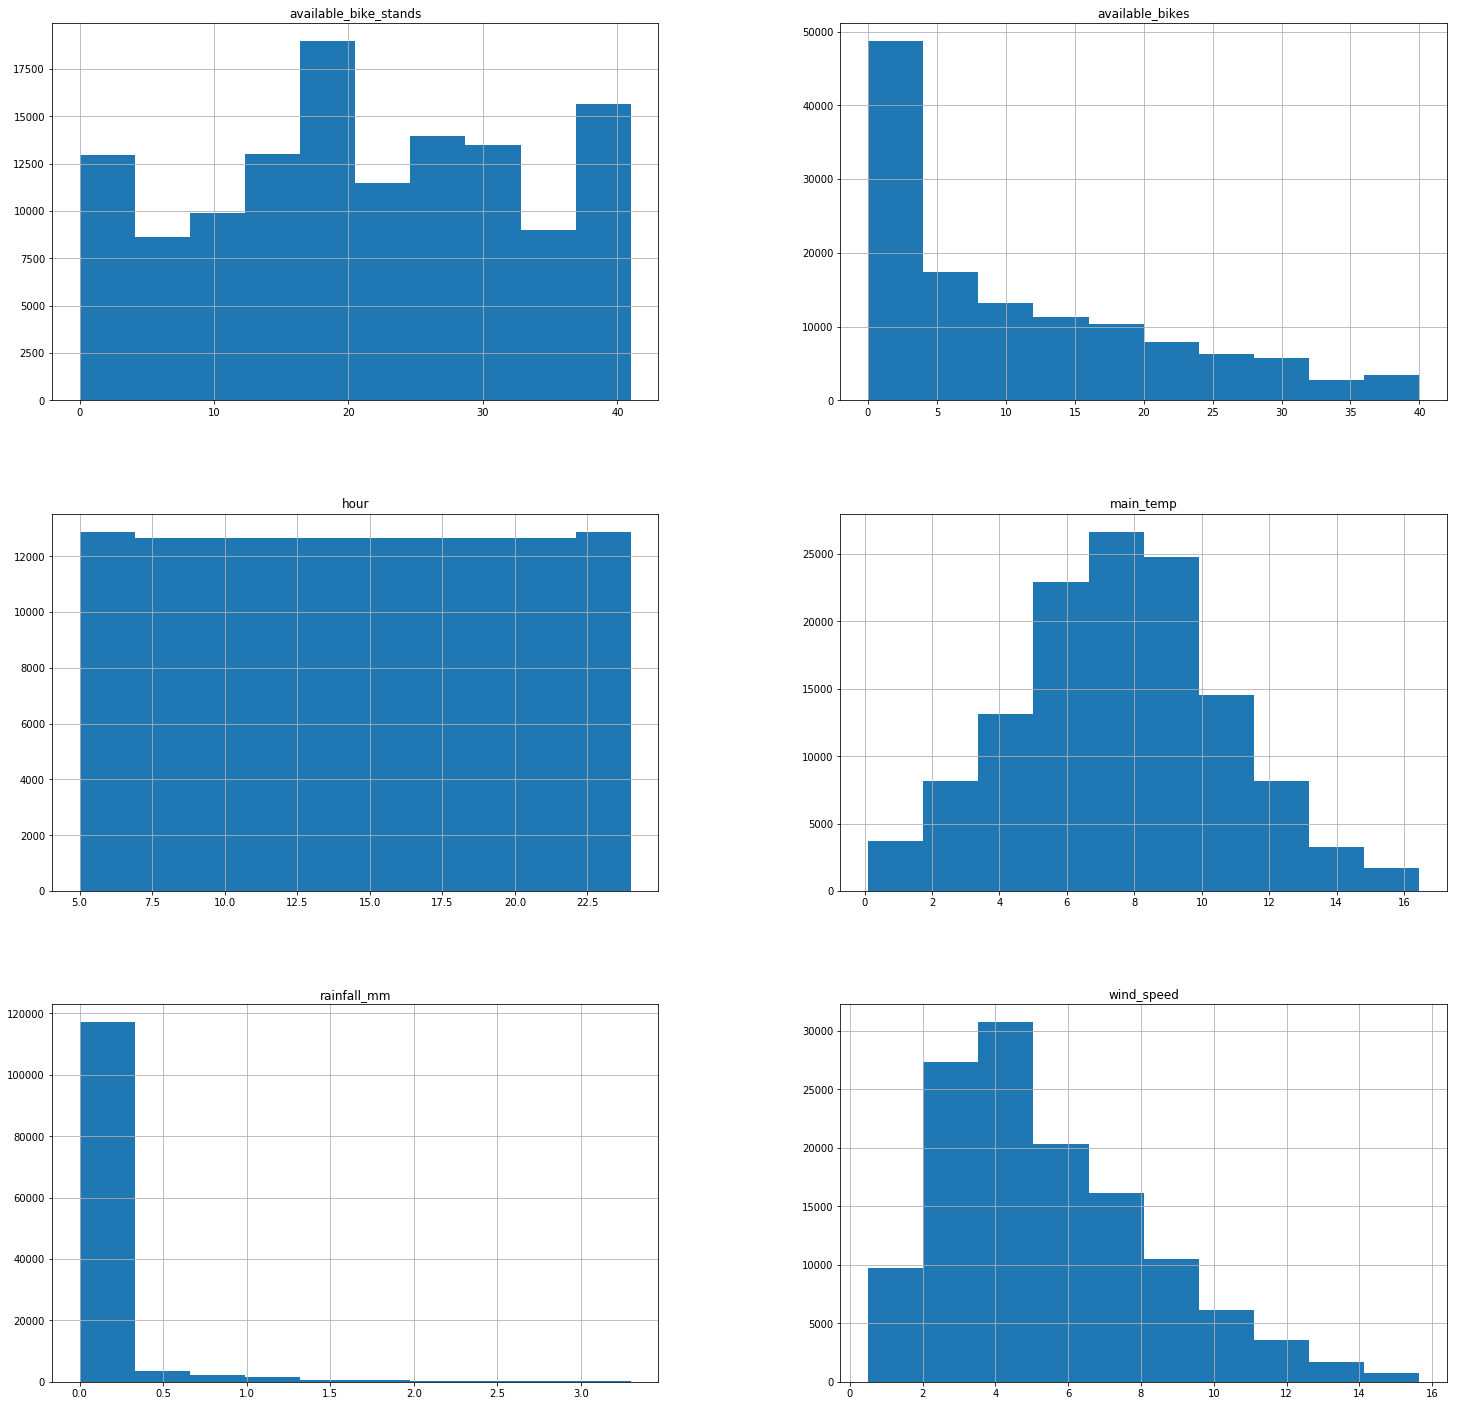

In [45]:
# Histogram plotting of all the continous features 
# Assigned to variable to suppress matlibplot messages
continous_hist_plot = df_db[continuous_columns].hist(figsize=(25,25))

**Points to note from continuous charts**

* available_bike_stands is a uniform distribution
* available_bikes and rainfall_mm look closest to an exponential shape
* main_temp is a normal distribution
* wind_speed looks to be a righ skewed unimodel distribution

### - Plot bar plots for all the categorical features

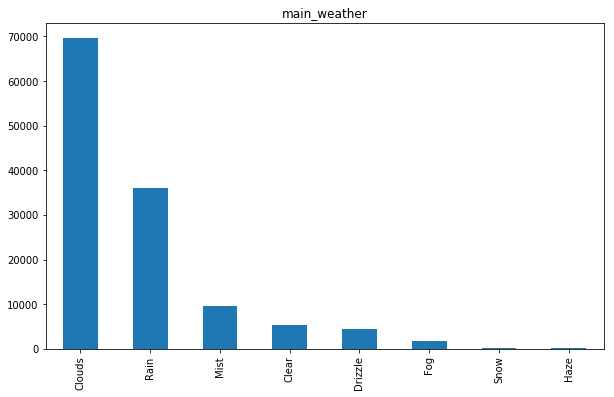

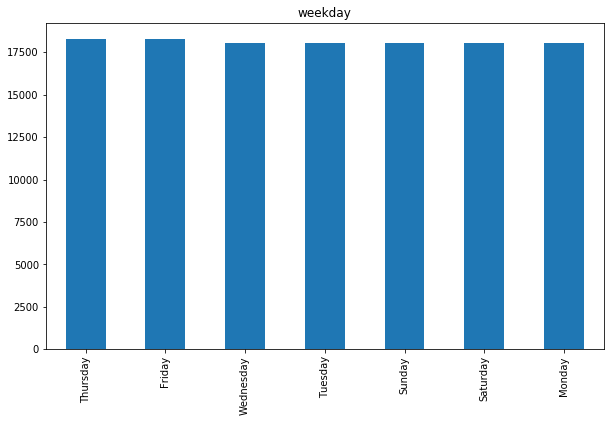

In [46]:
for column in categorical_columns:
    f = df_db[column].value_counts().plot(kind='bar', title=column,figsize=(10,6))
    plt.show()

**Points to note from categorical charts**
* Clouds is the most common weather, followed by rain.
* Days of the week are distributed close to evenly. This would depend on the way of the week the datascraping started on, and what it is currently on since the latest data pull.

### Check for null values

In [47]:
# Check if any null values are present in the dataframe
df_db.isnull().sum()

number                   0
available_bike_stands    0
available_bikes          0
main_weather             0
main_temp                0
rainfall_mm              0
wind_speed               0
hour                     0
weekday                  0
dtype: int64

This is good news, we have no missing data/null values present in our data. Overall I am pleased with the quality of our data, and will now begin the process of model creation. The next step is check how our data looks. This is important with respect to linear or non-linear relationships, and what model is best suited for training on this data.

### - Exploring data relationships

For data exploration, I have chosen two random stations on two random days to get an idea of how the shape of the relationship may look for bikes based on time of the day. I previously attempted to plot all the days and stations, but due to the volume, this produced meaningless charts. As such two scenarios will be investigated:
* Station 2 on a Wednesday
* Station 100 on a Saturday

In [76]:
# Create new dataframe 
wednesday_2 = df_db[df_db['weekday'] == 'Wednesday']
wednesday_2 = wednesday_2[wednesday_2['number'] == 2]

# Resample each time to the hour, and set values to be the average of that hour
wednesday_2 = wednesday_2.resample('H').mean()

# Drop NAN rows (which in this case are the hours between 01:00 and 05:00)
wednesday_2 = wednesday_2.dropna()

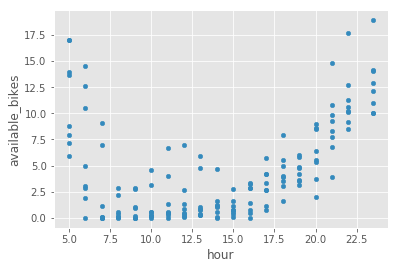

In [77]:
# Nicer plots
plt.style.use('ggplot')

# Scatter plot the features which displayed a high correlation from above

wednesday_2.plot(kind='scatter', x='hour', y='available_bikes')

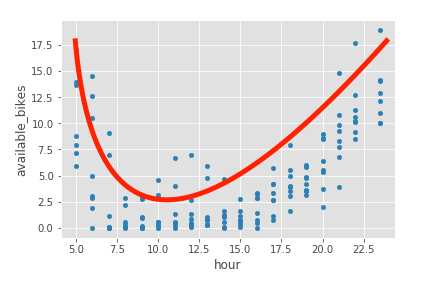

In [87]:
# Display image with trend line
Image("image_1.png")

As may be seen in the above graph the data is not linear. It roughly follows the pattern I would expect, that is from about 7am to 4pm, bike availability is low, due to workers commuting. As workers return home, we can see bike availability gradually increasing again.

In [78]:
# Create new dataframe 
saturday_100 = df_db[df_db['weekday'] == 'Saturday']
saturday_100 = saturday_100[saturday_100['number'] == 100]

# Resample each time to the hour, and set values to be the average of that hour
saturday_100 = saturday_100.resample('H').mean()

# Drop NAN rows (which in this case are the hours between 01:00 and 05:00)
saturday_100 = saturday_100.dropna()

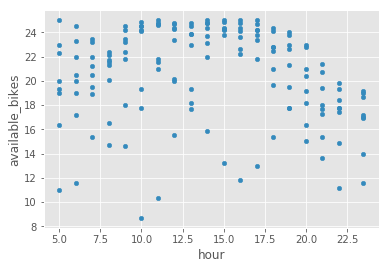

In [79]:
# Nicer plots
plt.style.use('ggplot')

# Scatter plot the features which displayed a high correlation from above

saturday_100.plot(kind='scatter', x='hour', y='available_bikes')

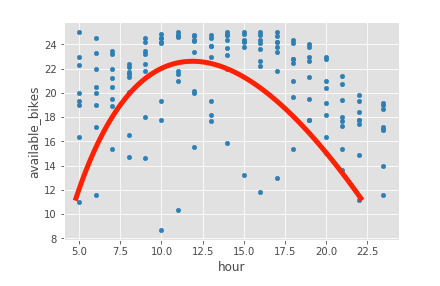

In [88]:
# Display image with trend line
Image("image_2.png")

Again, the graph above for bike availability on a weekend is non-linear. We can see mostly on weekends there is high bike availability, with slight drop offs early in the morning and late in the evening/night. I would hazard a guess that the largest drop off in availability in the evening is due to people leaving bars and clubs and looking for a quick and cheap means to get back home.

## Predictor Model Design

It is now time to design and develop the predictor model to be used for the creation of our pickle model files. As the data is of a non-linear type, a decision tree regressor was chosen due to its ability to fit polynomial shapes well. Within this regression model, parameter tuning would be controlled by using grid search and time series cross validation. Grid search is an approach to hyperparameter tuning. It methodically builds and evaluates a model for each combination of algorithm parameters specified in a grid. For our model, we are going to specify a max depth range of 1 -> 11, our performance metric will be the r2 score, and our validation will be assessed used time series split with cross validation.

Each model trained, which is outputted as a pickle file, will be unique to a given bike station on a given day of the week. This is for the following reasons:

* There will be a large variance of bike usage depending on the day of the week (working days versus weekend)
* There will be a significant difference in bike turnover depending on if the station is located in the city centre, or on the fringes of the city.

For model training, the key inputs for the model (once seperated out by day of the week and station number) are as follows:

* Hour of the day 
* Main weather conditions (broken down as binary categorical values)
* Main temperature degrees C
* Rainfall in mm

The target value is:

* Bikes available

In total there will 791 different pickle models generated. 

In [90]:
# Scoring function for models
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
       
    score = r2_score(y_true, y_predict)
    # Return the score
    return score

*fit_model* is where the model fitment occurs. All the data is broken into splits of 20. As previously mentioned, each day will be 20 hours in length in our dataset, so this is how we decide our splits. The regressor will be a decision tree regression model, and it will be allowed to train on a max depth ranging from 1 -> 11. We will score the model using the r2 value, and gridsearch will be used in conjunction with cross validation to generate the model with the best hyperparameters. 

To automate the process in future, a *models_score_dict* text file has been created. This keeps the score of each model in a text file. Our deployment of the predictor_model.py file on EC2 works as follows:

* Crontab is scheduled to run the predictor_model once a week at 3am on a Monday. This is so that we have new day of data for each day of the week.
* The model will run and generate a best score for the fitted model. It will then look up the previous best score for this model in the dictionary text file. If the new best score is worse than the previous best score, it will move on to the next model. If the new best score is better, it will overwrite the previous model, and update the dictionary with the new best score.

In this way we have automated the model training process and ensured the best model is the one that is stored on EC2.

One important point to note regarding our models is there are some prediction discrepancies, as visible in some of the recorded best scores. This is happening for several reasons:

* Decision tree regressors can be prone to overfitment. 
* Overfitment is happening mostly due to our small data set size. While we have a lot of rows of data, when you consider how many actual days this is (for our time series split samples) we in fact only have 8-9 days worth of data for each day of the week. This is small, and will cause overfitment.
* We do not currently have data that covers a wide spectrum of the weather. This means that as it gets warmer, the model is seeing weather it has not got much learning on, and is failing to generalise well.

All these issues should gradually reduce as the model continues to train on new data each week over the course of the year. This will help it generalise a lot better.

In [ ]:
def fit_model(X,y):
    
    n_splits = int(len(X)/20)
    
    cv_sets = TimeSeriesSplit(n_splits)

    regressor = DecisionTreeRegressor()
    
    params = {'max_depth': range(1,11)}
    
    scoring_fnc = make_scorer(performance_metric)
    
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cv_sets)
    
    grid = grid.fit(X, y)
    
    if key_name not in models_score_dict or models_score_dict[key_name] < best_score:
        models_score_dict[key_name] = best_score
        f = open('/home/ubuntu/oui-team/pickle_files/models_score_dict.txt', "w")
        f.write(str(models_score_dict))
        f.close()
        return grid.best_estimator_

    return grid.best_estimator_

A key point to note in the below function, *station_day_model*, is that is only uses whole days for its training. It will remove every row of data from the dataframe that does not finish on midnight for that day.

In [ ]:
def station_day_model(station_number, day_week, df_current, features):
    """ Function that creates a data frame for the given week day and station number. Ensures Whole days
    only are included in the data frame. Creates the file name for the pickle model. Checks the previous
    model best score versus the current model best score. If higher, updates the pickel model.

    :param station_number: current station number
    :param day_week: current day of the week
    :param df_current: data frame for model work
    :param features: list of features to be used for model
    :return: Void. Updates pickle models.
    """

    df_current = df_current[df_current['weekday'] == day_week]
    df_current = df_current[df_current['number'] == station_number]

    break_case = datetime.time(23, 59, 0)
    df_temp = df_current

    for index, row in df_current[::-1].iterrows():
        if index.time() == break_case:
            break
        else:
            df_temp = df_temp.drop(index)

    df_current = df_temp
    X = df_current[features]
    y = df_current.available_bikes

    file_name = "model_" + str(station_number) + "_" + day_week + ".pkl"
    key_name = file_name[:-4]

    f = open('/home/ubuntu/oui-team/pickle_files/models_score_dict.txt', "r")
    models_score_dict = f.read()
    models_score_dict = ast.literal_eval(models_score_dict)
    f.close()

    if key_name in models_score_dict:
        previous_best_score = models_score_dict[key_name]
    else:
        previous_best_score = -9999999

    reg = fit_model(X, y, models_score_dict, key_name)

    f = open('/home/ubuntu/oui-team/pickle_files/models_score_dict.txt', "r")
    models_score_dict = f.read()
    models_score_dict = ast.literal_eval(models_score_dict)
    f.close()

    current_best_score = models_score_dict[key_name]

    if previous_best_score < current_best_score:
        with open('/home/ubuntu/oui-team/pickle_files/' + file_name, 'wb') as handle:
            pickle.dump(reg, handle, pickle.HIGHEST_PROTOCOL)

In [ ]:
def create_models(station_array,df_db, features):
    """
    Loops through each station number and day of the week for model creation.
    :param station_array: list of all valid station numbers
    :param df_db: dataframe of all database data to be manipulated
    :param features: features to be used for model training
    :return: Void. Updates pickle models.
    """
    days =["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    for station_number in station_array:
        for day_week in days:
            station_day_model(station_number, day_week, df_db,features)



Machine learning models only work well with numerical inputs. In the below function, *start_modelling*, all categorical features are converted into binary values for the model.
We have also future proofed the model by including features that have not yet occurred in the database, so that when they do occur, the model will be able to continue to train without issue.

In [ ]:
def start_modelling():
    """
    Initial function. First calls SQL query to generate the dataframe from the databases. Creates a list
    with each unique station number. Converts all the categorical weather features to binary features for
    the purpose of modelling. Creates a df filtered by the desired features to be used for modelling.
    Makes a directory for the pickle files if it does not exist. Creates the mode best score dictionary if it does
    not exist. Calls the function to start the modelling process.
    :return:
    """

    # Download latest sql info
    df_db = sql_query_model()

    # Creates an array with every unique station number
    station_array = sorted(df_db.number.unique())

    # Make categorical info into binary
    main_weather_dummies = pd.get_dummies(df_db['main_weather'], prefix="main_weather")

    additional_main_weathers = ['main_weather_Thunderstorm', 'main_weather_Haze', 'main_weather_Squall',
                                'main_weather_Smoke', 'main_weather_Dust', 'main_weather_Tornado',
                                'main_weather_Ash']

    # This is ensuring that the order in which the model was originally trained is preserved
    # This is to allow for the reordering of data frame columns in the for loop below as new weather descriptions are
    # added to the database history
    categ_features = ['main_weather_Clouds', 'main_weather_Clear', 'main_weather_Rain', 'main_weather_Fog',
                      'main_weather_Drizzle', 'main_weather_Mist', 'main_weather_Snow'] + additional_main_weathers
    cont_features = ['hour', 'rainfall_mm', 'main_temp']

    features = cont_features + categ_features
    df_db = pd.concat([df_db, main_weather_dummies], axis=1)
    df_db = df_db.drop('main_weather', axis=1)

    for weather_descriptor in additional_main_weathers:
        if (weather_descriptor) not in df_db.columns:
            df_db[weather_descriptor] = 0

    # define the name of the directory to be created
    path_pickle = "pickle_files"

    if not os.path.exists(path_pickle):
        try:
            os.mkdir(path_pickle)
        except OSError:
            print ("Creation of the directory %s failed" % path_pickle)
        else:
            print ("Successfully created the directory %s " % path_pickle)

    path_pickle_file = '/home/ubuntu/oui-team/pickle_files/models_score_dict.txt'

    if not os.path.isfile(path_pickle_file):
        dict = {}
        f = open(path_pickle_file, "w")
        f.write(str(dict))
        f.close()

    # Make all the models
    create_models(station_array, df_db, features)


In [ ]:
start_modelling()